# Estimating average energy use by property type in England
James Thomas\
19th August 2020

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence CC BY-SA 4.0" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>

## Summary

Using published statistics for each of the nearly 34,000 Lower Super Output Areas (LSOAs) in England, I have estimated the annual gas and electricity use of the average domestic property by building type (detached, semi-deteched, terraced, flat, bungalow). Specifically, I created a model using council tax property type data and Index of Multiple Deprivation data for each LSOA, supplemented by 20-year average regional heating degree day (DDH) data, to predict median annual gas and electricity comsumptions of that LSOA. I then used this model to estimate average gas and electricity use for each property type.

## Table of contents

1. [Introduction](#Introduction)
2. [Data exploration](#Data-exploration)
    1. [Gas data](#Gas-data)
    2. [Electricity data](#Electricity-data)
    3. [Council tax property data](#Council-tax-property-data)
    4. [Index of Multiple Deprivation data](#Index-of-Multiple-Deprivation-data)
    5. [Heating degree day data](#Heating-degree-day-data)
3. [Data preparation](#Data-preparation)
    1. [Possible transforms](#Possible-transforms)
4. [Modelling](#Modelling)
    1. [Train, validation, test split](#Train,-validation,-test-split)
    2. [Linear model](#Linear-model)
    3. [Random forest model](#Random-forest-model)
    4. [Neural network model](#Neural-network-model)
5. [Evaluation](#Evaluation)
    1. [Evaluation on test set](#Evaluation-on-test-set)
    2. [Errors analysis](#Errors-analysis)
    3. [Model stability and suitability for extrapolation](#Model-stability-and-suitability-for-extrapolation)
6. [Predictions](#Predictions)
    1. [Retrain on all data](#Retrain-on-all-data)
    2. [Prediction of typical energy consumptions](#Prediction-of-typical-energy-consumptions)
7. [Further work](#Further-work)
8. [Acknowledgements](#Acknowledgements)
9. [References](#References)

## Introduction

The UK's Department for Business, Energy & Industrial Strategy (BEIS) publishes annual gas consumption statistics for each Lower and Middle Super Output Area (LSOA and MSOA) in England and Wales, and for each Data Zone in Scotland. There are nearly 34,000 LSOAs in England and Wales – the Office for National Statisics has some [definitions of statistical geographies](#ref-ons-stat-guide) and there is also a useful [beginner’s guide to statistical geographies](#ref-ocsi-stat-guide) provided by OCSI if you would like to find out more.

## Data exploration

In [1]:
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
K = keras.backend

%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
plt.rc("figure", figsize=(10, 6))
sns.set_context("talk")

### Gas data

The BEIS [annual gas consumption dataset](#ref-beis-gas) for 2018 contains both total, mean and median consumption of each LSOA, plus the number of properties in that LSOA. All energy values are in kWh, and the column `MEAN` is just the column `KWH` divided by `METERS`.

In [2]:
gas = pd.read_csv("../raw_data/gas/LSOA_GAS_2018.csv", index_col="LSOACode")
gas.tail()

,LAName,LACode,MSOAName,MSOACode,LSOAName,METERS,KWH,MEAN,MEDIAN
LSOACode,,,,,,,,,
W01001301,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008C,802,1.031799e+07,12865.32567,12502.44858
W01001308,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008D,505,6.875167e+06,13614.19304,13265.42605
W01001309,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008E,540,7.418312e+06,13737.61563,13762.48776
W01001898,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008F,447,6.092790e+06,13630.40358,13237.02253
Unallocated,Unallocated,Unallocated,Unallocated,Unallocated,Unallocated,106759,1.218870e+09,11417.02117,10249.75514


Some data is unallocated – either because some LSOAs have few gas users and so the data is deemed to disclose personal information, or because the address information for a meter point is incomplete and an address cannot be reliably determined. In these cases the consumption is aggregated at the bottom of the data and not provided at the LSOA level. I've ignored this row as it upsets the histograms I'm about to plot.

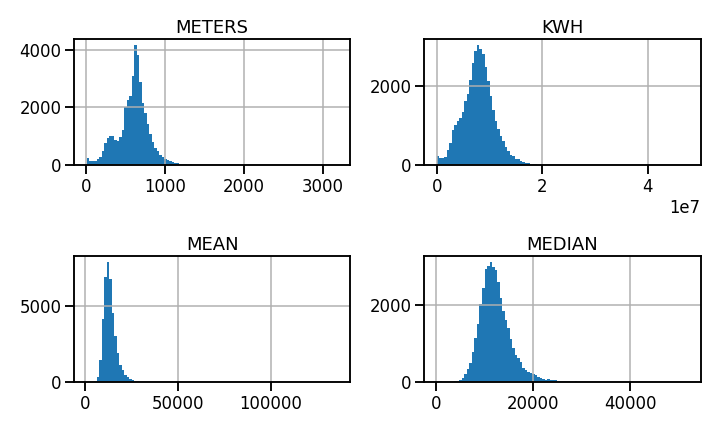

In [3]:
# Split off the unallocated data
gas, unallocated_gas = gas.iloc[:-1], gas.iloc[-1]

gas.hist(bins=100)
plt.tight_layout()

None of the distributions are symmetric – all having a long right-hand tail. The distribution of meters per LSOA is slightly odd, with evidence of a second peak on the left-hand side. As  LSOAs have roughly the same number of properties each, this could be something like rural areas which have on average fewer gas-connected homes, instead relying on oil, LPG, biomass, other solid fuels, heat pumps or other electric heating.

Looking at the modes of the distributions, the most common number of meter points per LSOA is around 650, and the most common consumption per LSOA is around 8,000,000 kWh. This gives a mean consumption per property of around 12,000 kWh. The distribution of median consumptions is not quite the same, with the peak occuring around 11,000 kWh.

If we could look at the individual distribution of consumptions in every LSOA, then nearly 99% of them would have a positive skew (i.e. a right-hand tail), because their mean consumption is greater than their median. This is equivalent to a few very large gas consumers impacting the mean.

In [4]:
(gas["MEDIAN"] < gas["MEAN"]).mean()

0.9892986909561495

It is difficult to have a long left-hand tail (because it's not possible to use a negative quantity of gas), although some 1% of LSOAs do have a mean consumption lower than the median.

I extracted the medians from the 2018 dataset and used these as the prediction target, believing these to be the fairest estimate of the consumption of average house in that LSOA that I had available. Note that BEIS also provide a postcode-level dataset, giving much finer resolution (where the address data is available and this does not compromise privacy), however the other statistics I use in the model are only available down to LSOA level, so I didn't break this down any further.

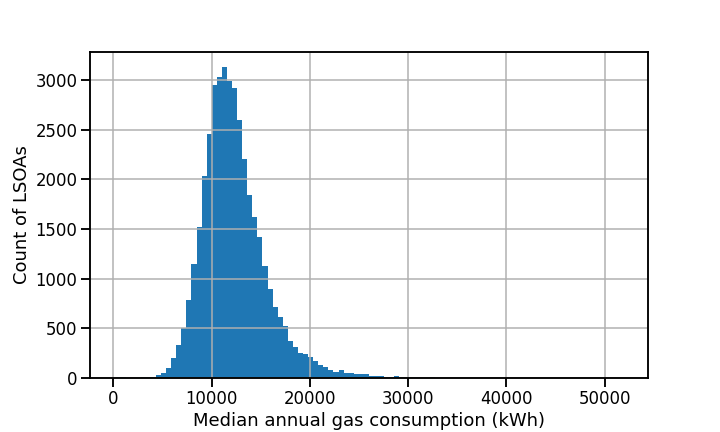

In [5]:
gas = gas["MEDIAN"]
gas.hist(bins=100)
plt.xlabel("Median annual gas consumption (kWh)")
plt.ylabel("Count of LSOAs");

It is worth pointing out that these consumptions are [weather corrected](#ref-ng-gas-method) according to a National Grid method using a composite weather variable, which is mostly dependent on temperature. It would appear that this weather correction has removed the dependence of gas consumption on temperature (see <a href="examining_weather_dependence.ipynb">*Examining weather dependence*</a>), however heating degree days (a form of temperature data) were included in the analysis to see if they improved the performance of the model (and for the modelling of electricity demand, which is not weather corrected).

### Electricity data

The BEIS [annual electricity consumption dataset](#ref-beis-elec) for 2018 is similar to the gas dataset, containing total, mean and median consumption of each LSOA, plus the number of properties in that LSOA. All energy values are in kWh and, as before, some data is unallocated.

In [6]:
elec = pd.read_csv("../raw_data/electricity/LSOA_ELEC_2018.csv", index_col="LSOACode")
elec.tail()

,LAName,LACode,MSOAName,MSOACode,LSOAName,METERS,KWH,MEAN,MEDIAN
LSOACode,,,,,,,,,
W01001301,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008C,799,2.533021e+06,3170.239174,2923.30
W01001308,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008D,509,1.908251e+06,3749.019338,3335.20
W01001309,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008E,538,1.797512e+06,3341.100372,3054.35
W01001898,Merthyr Tydfil,W06000024,Merthyr Tydfil 008,W02000415,Merthyr Tydfil 008F,685,2.524078e+06,3684.784964,2875.50
Unallocated,Unallocated,Unallocated,Unallocated,Unallocated,Unallocated,41222,1.376141e+08,3338.365499,2351.45


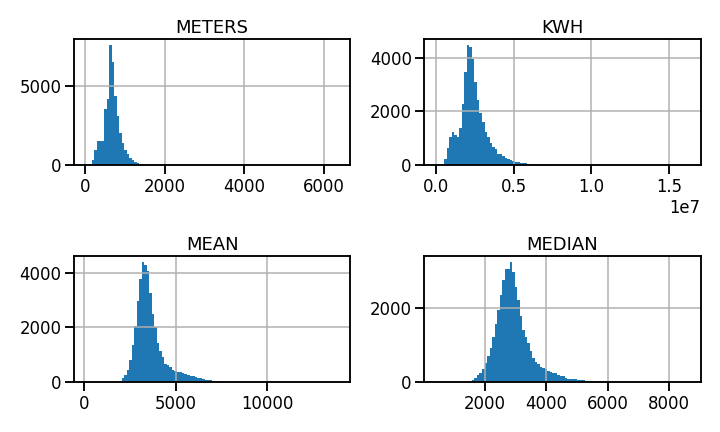

In [7]:
# Split off the unallocated data
elec, unallocated_elec = elec.iloc[:-1], elec.iloc[-1]

elec.hist(bins=100)
plt.tight_layout()

The averages have similar right-hand tails, and looking individual LSOAs, this time almost all have a median consumption less than their mean (so the distribution of consumptions in individual LSOAs has a positive skew, or a right-hand tail).

In [8]:
(elec["MEDIAN"] < elec["MEAN"]).mean()

0.9994487849302593

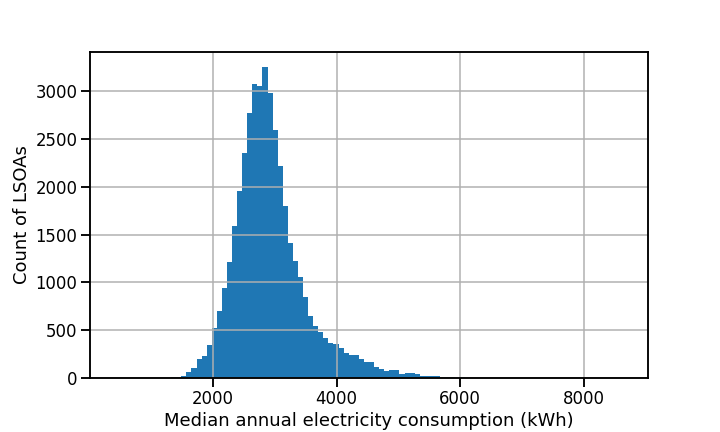

In [9]:
elec = elec["MEDIAN"]
elec.hist(bins=100)
plt.xlabel("Median annual electricity consumption (kWh)")
plt.ylabel("Count of LSOAs");

Unlike the gas consumptions, the electricity consumptions are not weather corrected. <a href="examining_weather_dependence.ipynb">*Examining the weather dependence*</a> of the electricity data shows there is no obvious relationship between electricity consumption and temperature. Some UK homes are heated using electricity, whether by heat pump or direct electric heating (e.g. night storage heater), however as of today the predominant energy source for heating is gas. Domestic electricity consumption is dominated by non-heating consumption which shows less weather dependence (other than, for instance, increased use of lighting in the winter time).

### Council tax property data

The Valuation Office Agency maintains [tables of properties by Council Tax band](#ref-ctsop) in England and Wales. For each LSOA, counts of properties are available per property type and number of bedrooms, which is further split by Council Tax band.

Properties are split into one of: bungalow, flat/maisonette, terraced, semi-detached, detached, annexe, other and unknown. Bedrooms are split into: one, two, three and four (or more) bedrooms. Counts are rounded to the nearest 10, with a special treatment for small numbers of properties: zero is reported as `0`, between one and five is reported as `-` (converted to `NaN`), and five or greater is reported as `10`, `20`, etc.

In [10]:
houses = pd.read_csv("../raw_data/council_tax/LSOA_CTSOP3.1_2018.csv", index_col="ECODE", na_values="-", thousands=",", encoding="latin")
houses.iloc[100:105]

,GEOGRAPHY,BA_CODE,AREA_NAME,BAND,TYPE_BUNGALOW_1,TYPE_BUNGALOW_2,TYPE_BUNGALOW_3,TYPE_BUNGALOW_4,TYPE_BUNGALOW_UNKW,BUNGALOW,...,TYPE_HOUSE_DETACHED_1,TYPE_HOUSE_DETACHED_2,TYPE_HOUSE_DETACHED_3,TYPE_HOUSE_DETACHED_4,TYPE_HOUSE_DETACHED_UNKW_RND,HOUSE_DETACHED,ANNEXE,OTHER,UNKNOWN,ALL_PROPERTIES
ECODE,,,,,,,,,,,,,,,,,,,,,
E01020613,LSOA,NaN,County Durham 002A,All,0.0,20.0,10.0,0.0,0.0,30.0,...,0.0,NaN,90.0,90.0,0.0,180.0,0.0,NaN,NaN,560.0
E01020613,LSOA,NaN,County Durham 002A,A,0.0,NaN,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,40.0
E01020613,LSOA,NaN,County Durham 002A,B,0.0,10.0,NaN,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
E01020613,LSOA,NaN,County Durham 002A,C,0.0,10.0,NaN,0.0,0.0,10.0,...,0.0,NaN,60.0,10.0,0.0,70.0,0.0,0.0,0.0,180.0
E01020613,LSOA,NaN,County Durham 002A,D,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,0.0,30.0,70.0,0.0,100.0,0.0,0.0,NaN,110.0


For simplicity, I discarded the breakdowns by number of bedrooms and Council Tax band, as well as the property types annexe, other and unknown. I estimated the `-` values with an average of 2.5. Counts were then normalised by the total number of properties in one of the five categories, to produce ratios between zero and one.

In [11]:
houses = houses.fillna(2.5)  # <5 but not >0
houses = houses[(houses["GEOGRAPHY"] == "LSOA") & (houses["BAND"] == "All")]
houses = houses[[col for col in houses.columns if col.startswith("BUNG") or col.startswith("FLAT") or col.startswith("HOUSE")]]
houses = houses.div(houses.sum(axis=1), axis=0)

houses.head()

,BUNGALOW,FLAT_MAIS,HOUSE_TERRACED,HOUSE_SEMI,HOUSE_DETACHED
ECODE,,,,,
E01020634,0.084507,0.042254,0.338028,0.281690,0.253521
E01020635,0.187500,0.062500,0.312500,0.203125,0.234375
E01020636,0.168675,0.012048,0.445783,0.361446,0.012048
E01020654,0.141026,0.051282,0.397436,0.217949,0.192308
E01020676,0.157143,0.028571,0.557143,0.142857,0.114286


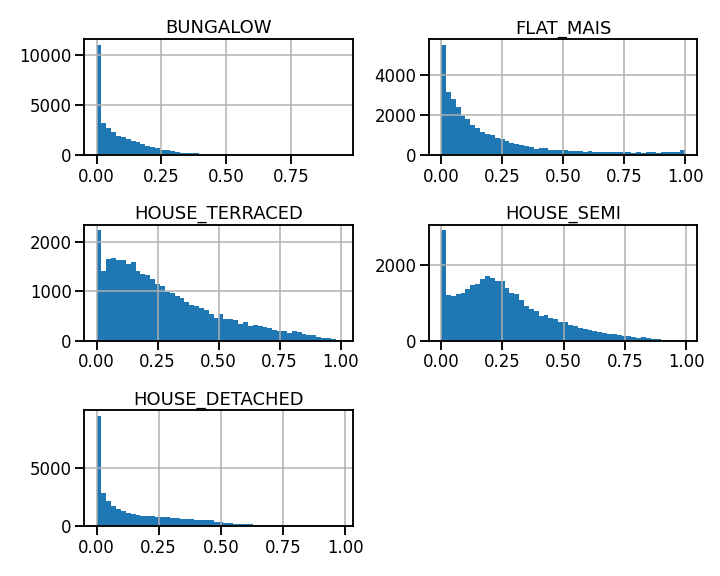

In [12]:
houses.hist(bins=50, figsize=(10, 8))
plt.tight_layout()

### Index of Multiple Deprivation data

The Ministry of Housing, Communities and Local Government publishes [Index of Multiple Deprivation](#ref-imd) (IMD) by LSOA in England. Similar statistics are also availble for Northern Ireland, Scotland and Wales.

The IMD is the weighted average of indices representing:
* Income Deprivation
* Employment Deprivation
* Education, Skills and Training Deprivation
* Health Deprivation and Disability
* Crime
* Barriers to Housing and Services
* Living Environment Deprivation

Areas are then ranked from most deprived to least deprived, and their ranking and decile (1-10) is published.

In [13]:
imd = pd.read_csv("../raw_data/imd/LSOA_IMD_2019.csv", index_col="lsoa11cd")
imd.head()

,FID,lsoa11nm,IMDRank,IMDDecil,Shape__Area,Shape__Length
lsoa11cd,,,,,,
E01000001,1,City of London 001A,29199,9,343894.195702,3682.367055
E01000002,2,City of London 001B,30379,10,583453.103058,3910.314357
E01000003,3,City of London 001C,14915,5,147833.971008,1834.896718
E01000005,4,City of London 001E,8678,3,491901.220234,3483.118352
E01000006,5,Barking and Dagenham 016A,14486,5,372254.489704,3108.596473


For simplicity, I used the decile as it is already uniformly distributed between 0 and 10. The dataset also contained entries for LSOAs in Wales, however they did not contain any data and so were removed.

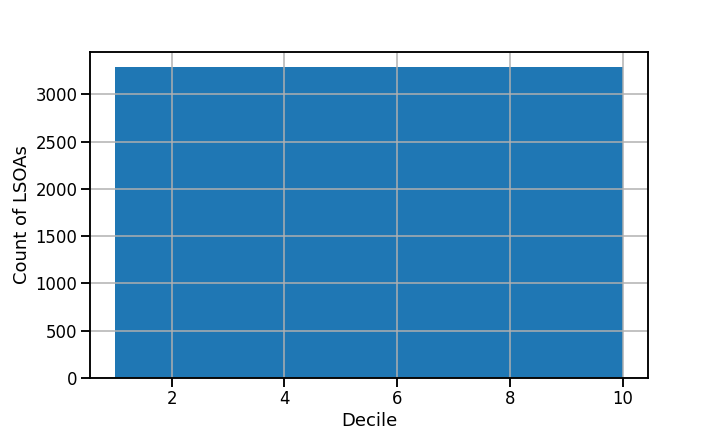

In [14]:
english_lsoas = imd.index.str[0] == "E"
valid_decile = imd["IMDDecil"] > 0
imd = imd.loc[english_lsoas & valid_decile, "IMDDecil"]
imd.hist(bins=10)
plt.xlabel("Decile")
plt.ylabel("Count of LSOAs");

### Heating degree day data

The Energy Management Register provides [20-year average degree day values](#ref-ddh) for [18 regions in the UK](#ref-ddh-map):

<figure>
    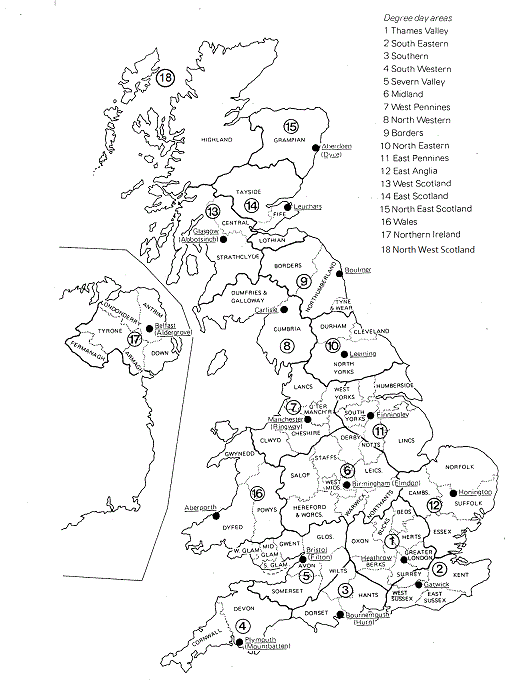
    <figcaption>DDH regions. Source: <a href="#ref-ddh-map">Vesma</a>.</figcaption>
</figure>

Both heating degree day (HDD or DDH) and cooling degree day (CDD) values are provided at various base temperatures and split by month.

In [15]:
ddh = pd.read_excel(
    "../raw_data/ddh/uk_20year.xls",
    skiprows=5,
    header=None,
    names=["Month", "Region", "HDD18.5", "HDD15.5", "HDD5.0", "CDD15.5", "CDD5.0", "CDD-20"],
).set_index(["Month", "Region"]).dropna()
ddh.iloc[10:13]

,,HDD18.5,HDD15.5,HDD5.0,CDD15.5,CDD5.0,CDD-20
Month,Region,,,,,,
1900-11-15 00:00:00,01EEO: Thames Valley,296.5800,207.0250,66.835,0.450,120.175,858.375
1900-12-15 00:00:00,01EEO: Thames Valley,382.8450,289.8600,130.245,0.025,71.730,810.725
Year,01EEO: Thames Valley,2635.0125,1771.6125,634.800,410.955,2621.950,11605.855


I chose to extract the annual DDH values at a base temperature of 15.5 °C.

In [16]:
ddh = ddh.loc["Year"]["HDD15.5"]
ddh.index = ddh.index.str[:2].astype(int)
ddh.head()

Region
1    1771.6125
2    2035.7200
3    1942.8200
4    1694.1050
5    1890.8850
Name: HDD15.5, dtype: float64

I was unable to locate a mapping between the DDH regions and modern LSOAs, so instead I manually georeferenced the map of 18 regions via 22 landmarks around the coast using [QGIS](#ref-qgis). By overlaying the LSOAs over this raster image, I was able to approximately assign LSOAs to a region.

<figure>
    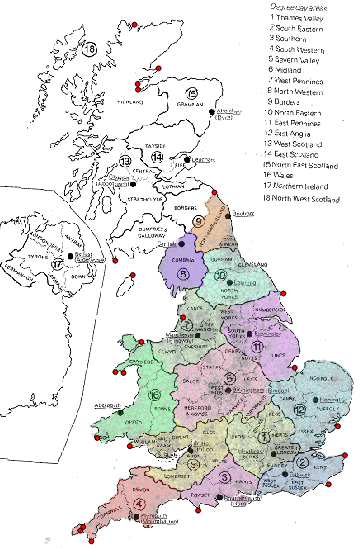
    <figcaption>LSOAs overlaid over DDH region map, showing allocated regions and alignment points used for georeferencing. Projected using EPSG:27700. Map layers: <a href="#ref-boundaries">ONS</a>, <a href="#ref-vesma">Vesma</a>.</figcaption>
</figure>

In [17]:
regions = pd.read_csv("../map_data/lsoa_region_lookup.csv", index_col="LSOA11CD")
regions = regions.loc[regions.index.dropna()]
regions.head()

,LSOA11NM,LSOA11NMW,Region
LSOA11CD,,,
E01013150,North East Lincolnshire 013B,North East Lincolnshire 013B,11
E01015580,Swindon 007D,Swindon 007D,5
E01023601,North Hertfordshire 010A,North Hertfordshire 010A,1
E01024217,Dover 005B,Dover 005B,2
E01000722,Bromley 023A,Bromley 023A,1


In [18]:
regions = regions["Region"].dropna().astype(int)
regions.head()

LSOA11CD
E01013150    11
E01015580     5
E01023601     1
E01024217     2
E01000722     1
Name: Region, dtype: int64

In [19]:
ddh_by_lsoa = regions.map(ddh).dropna().rename("DDH")
ddh_by_lsoa.head()

LSOA11CD
E01013150    2112.7250
E01015580    1890.8850
E01023601    1771.6125
E01024217    2035.7200
E01000722    1771.6125
Name: DDH, dtype: float64

## Data preparation

### Possible transforms

#### Gas and electricity data
The median gas and electricity consumptions are not normally distributed, however in each case an exponential transform makes them approximately normal (albeit with slightly longer tails).

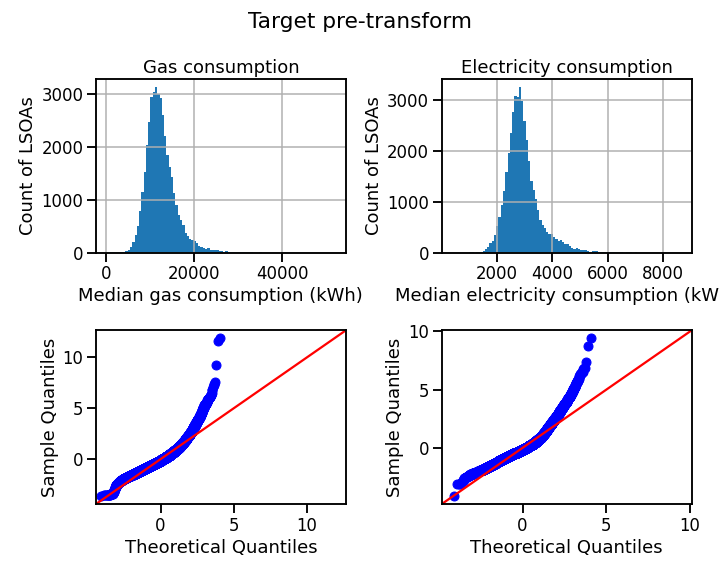

In [20]:
def plot_target_distribution(gas, elec):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    gas.hist(bins=100, ax=ax)
    ax.set_title("Gas consumption")
    ax.set_xlabel("Median gas consumption (kWh)")
    ax.set_ylabel("Count of LSOAs")

    ax = axs[1, 0]
    sm.qqplot(gas, fit=True, line="45", ax=ax)

    ax = axs[0, 1]
    elec.hist(bins=100, ax=ax)
    ax.set_title("Electricity consumption")
    ax.set_xlabel("Median electricity consumption (kWh)")
    ax.set_ylabel("Count of LSOAs")

    ax = axs[1, 1]
    sm.qqplot(elec, fit=True, line="45", ax=ax)
    
plot_target_distribution(gas, elec)
plt.suptitle("Target pre-transform")
plt.tight_layout()

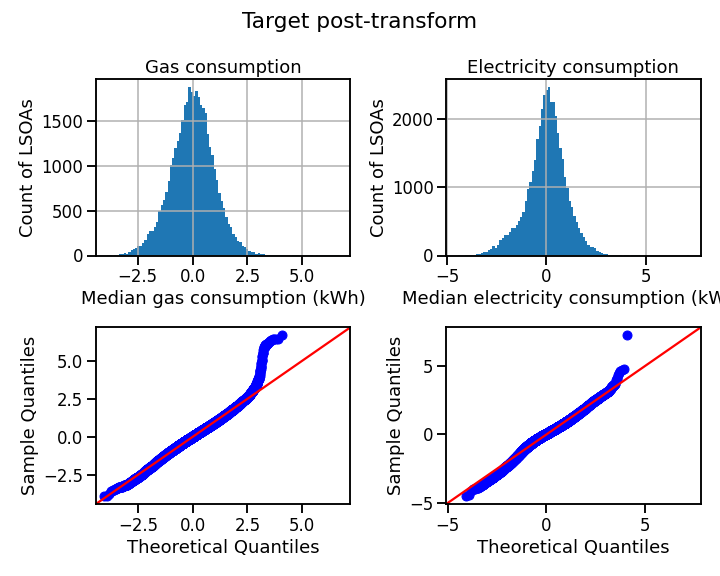

In [21]:
gas_mode = 12_000  # (all these are approx.)
gas_loc = 0.371
gas_scale = 0.092

elec_mode = 2_800
elec_loc = 0.358
elec_scale = 0.070

def transform_gas(data):
    return (np.exp(-data/gas_mode) - gas_loc) / gas_scale

def inverse_transform_gas(data):
    return -np.log(data*gas_scale + gas_loc) * gas_mode

def transform_elec(data):
    return (np.exp(-data/elec_mode) - elec_loc) / elec_scale

def inverse_transform_elec(data):
    return -np.log(data*elec_scale + elec_loc) * elec_mode
   
plot_target_distribution(
    transform_gas(gas),
    transform_elec(elec),
)
plt.suptitle("Target post-transform")
plt.tight_layout()

#### Property type data

The property type ratios, although contrained within the range 0-1, are far from normally distributed.

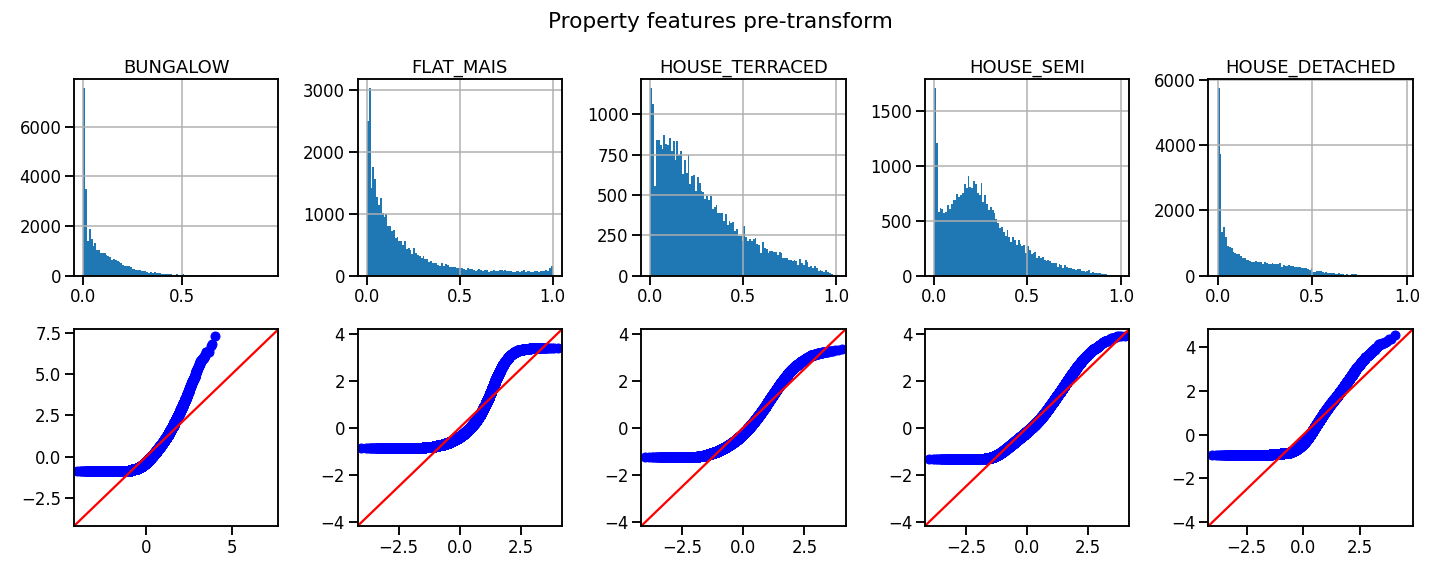

In [22]:
def plot_property_distribution(houses):
    fig, axs = plt.subplots(2, 5, sharey=False, figsize=(20, 8))

    for i, property_type in enumerate(["BUNGALOW", "FLAT_MAIS", "HOUSE_TERRACED", "HOUSE_SEMI", "HOUSE_DETACHED"]):
        ax = axs[0, i]
        houses[property_type].hist(bins=100, ax=ax)
        ax.set_title(property_type)

        ax = axs[1, i]
        sm.qqplot(houses[property_type], fit=True, line="45", ax=ax)

    for i in range(5):
        axs[1, i].set_xlabel(None)
        axs[1, i].set_ylabel(None)

plot_property_distribution(houses)
plt.suptitle("Property features pre-transform")
plt.tight_layout()

A simply fractional power transform keeps them within the range 0-1, but with an average closer to 0.5.

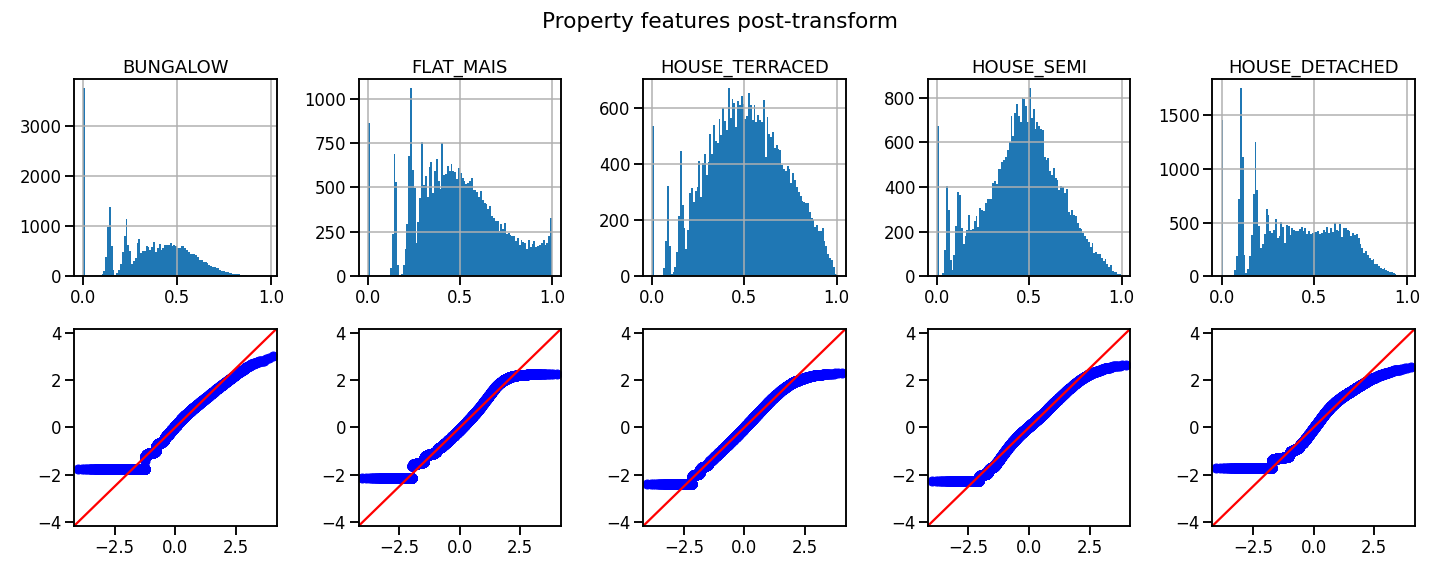

In [23]:
def transform_bungalow(data):
    return data**0.35

def transform_flat(data):
    return data**0.35

def transform_terraced(data):
    return data**0.45

def transform_semi(data):
    return data**0.5

def transform_detached(data):
    return data**0.4

def transform_houses(data):
    return pd.DataFrame({
        "BUNGALOW": transform_bungalow(data["BUNGALOW"]),
        "FLAT_MAIS": transform_flat(data["FLAT_MAIS"]),
        "HOUSE_TERRACED": transform_terraced(data["HOUSE_TERRACED"]),
        "HOUSE_SEMI": transform_semi(data["HOUSE_SEMI"]),
        "HOUSE_DETACHED": transform_detached(data["HOUSE_DETACHED"]),
    })

plot_property_distribution(transform_houses(houses))
plt.suptitle("Property features post-transform")
plt.tight_layout()

#### Degree day heating data

The DDH is definitely not normally distributed. The are only 13 unique values due to the large region size, and the distribution is almost bimodal. A simple subtraction of the mean and rescaling by twice the standard deviation yields values roughly within the range ±1.

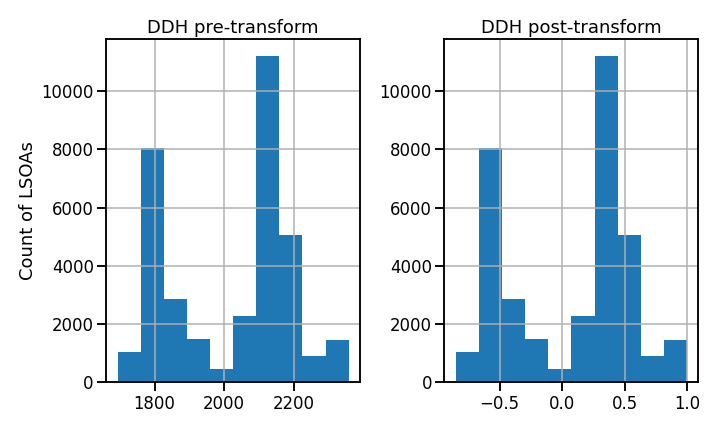

In [24]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
ddh_by_lsoa.hist(ax=ax)
ax.set_title("DDH pre-transform")
ax.set_ylabel("Count of LSOAs")

def transform_ddh(data):
    data = (data - 2000) / 360
    return data
    # return data**2 * np.sign(data)

ax = axs[1]
transform_ddh(ddh_by_lsoa).hist(ax=ax)
ax.set_title("DDH post-transform")

plt.tight_layout()

## Modelling

The input features are the property type ratios for the LSOA, the deprivation deciles of the LSOA and the DDH of the region in which the LSOA is located. The output quantities are the median annual gas and electricity consumption of domestic properties in the LSOA.

This is a multi-output regression problem, and three algorithms were selected for modelling:
* a linear regression model
* a random forest
* a feedforward neural network

### Train, validation, test split

I first split the data into train, validation and test sets (in the ratios 60%, 20% and 20% respectively).

In [26]:
# Combine data and drop rows with missing data (no imputing)
X = pd.concat([
    houses,
    imd,
    ddh_by_lsoa,
], axis=1).dropna()

y = pd.concat([
    gas.rename("Gas"),
    elec.rename("Elec"),
], axis=1).dropna()

# Ensure only data points used in model are ones with both X and y data
combined_index = X.index.intersection(y.index)
X = X.loc[combined_index]
y = y.loc[combined_index]

# Train/validation/test split (60:20:20)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1234)

print("Shapes:")
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val", X_val.shape, "y_val", y_val.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

Shapes:
X_train (19217, 7) y_train (19217, 2)
X_val (6406, 7) y_val (6406, 2)
X_test (6406, 7) y_test (6406, 2)


### Linear model

The linear model is a simple linear regression model with no regularisation. No feature or target transformations were applied. This serves as a baseline model.

In [58]:
%%time

linear_model = LinearRegression()

linear_model.fit(
    X_train,
    y_train,
)

print("Linear model r² scores:")
print(f"Training   = {linear_model.score(X_train, y_train):0.3f}")
print(f"Validation = {linear_model.score(X_val, y_val):0.3f}")

Linear model r² scores:
Training   = 0.419
Validation = 0.430
CPU times: user 133 ms, sys: 300 µs, total: 134 ms
Wall time: 29.9 ms


The performance of the linear model can be improved upon by calculating polynomial features (i.e. ${x_0}^2$, ${x_1}^2$, $x_0x_1$, ${x_0}^2x_1$, $\ldots$).

I henceforth use the term **polynomial model** to refer to this linear model with polynomial features. I used cross-validation to determine the best degree of the polynomial features, bearing in mind that using this technique increases training time exponentially with degree.

In [28]:
poly_model = make_pipeline(
    PolynomialFeatures(),
    LinearRegression(),
)

grid_search = GridSearchCV(
    poly_model,
    {
        "polynomialfeatures__degree": range(1, 7),
    },
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(
    X_train,
    y_train,
);

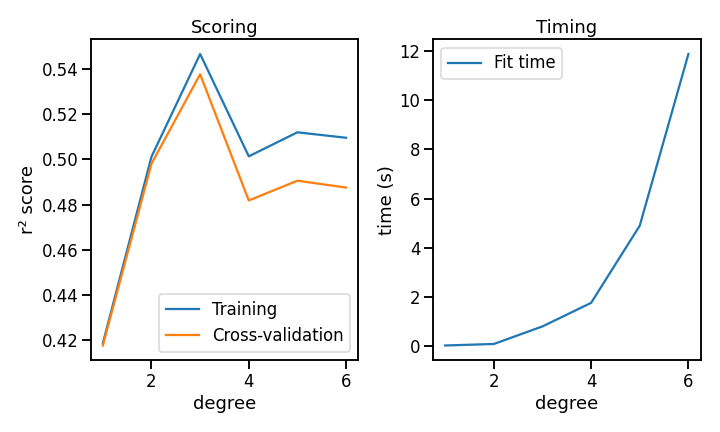

In [29]:
plt.subplot(121)
plt.title("Scoring")
x_data = grid_search.cv_results_['param_polynomialfeatures__degree']
plt.plot(x_data, grid_search.cv_results_["mean_train_score"], label="Training")
plt.plot(x_data, grid_search.cv_results_["mean_test_score"], label="Cross-validation")
plt.xlabel("degree")
plt.ylabel("r² score")
plt.legend()

plt.subplot(122)
plt.title("Timing")
plt.plot(x_data, grid_search.cv_results_['mean_fit_time'], label="Fit time")
plt.xlabel("degree")
plt.ylabel("time (s)")
plt.legend()

plt.tight_layout()

It looks like the best performing degree (in terms of generalisation and training time) is 3, i.e. cubic powers.

In [54]:
%%time

poly_model = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(),
)

poly_model.fit(
    X_train,
    y_train,
)

print("Polynomial model r² scores:")
print(f"Training   = {poly_model.score(X_train, y_train):0.3f}")
print(f"Validation = {poly_model.score(X_val, y_val):0.3f}")

Polynomial model r² scores:
Training   = 0.545
Validation = 0.545
CPU times: user 1.33 s, sys: 750 ms, total: 2.08 s
Wall time: 304 ms


### Random forest model

I achieved slightly better validation performance on the random forest model by transforming the target variables, having the affect of removing their long tails.

I chose to optimise the **number of decision trees** and their **maximum depth** by iterating over each combination of parameters (as there are only two, this isn't that costly). To speed things up slightly, I used a `ParameterGrid` directly rather than using k-fold `GridSearchCV`, which will take *k* times longer due to the repeated training.

In [32]:
def transform_target(y):
    y = np.array(y)
    y[:, 0] = transform_gas(y[:, 0])
    y[:, 1] = transform_elec(y[:, 1])
    return y

def inverse_transform_target(y):
    y = np.array(y)
    y[:, 0] = inverse_transform_gas(y[:, 0])
    y[:, 1] = inverse_transform_elec(y[:, 1])
    return y

In [ ]:
rf_model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=1234),
    func=transform_target,
    inverse_func=inverse_transform_target,
)

parameter_grid = ParameterGrid({
    "regressor__n_estimators": range(10, 71, 5),
    "regressor__max_depth": range(10, 21, 2),
})

train_scores = []
val_scores = []

for parameters in tqdm(parameter_grid):
    rf_model = rf_model.set_params(**parameters)
    rf_model.fit(X_train, y_train)

    train_scores.append(rf_model.score(X_train, y_train))
    val_scores.append(rf_model.score(X_val, y_val))

With only two hyperparameters to tune, the results can be displayed nicely on a contour plots:

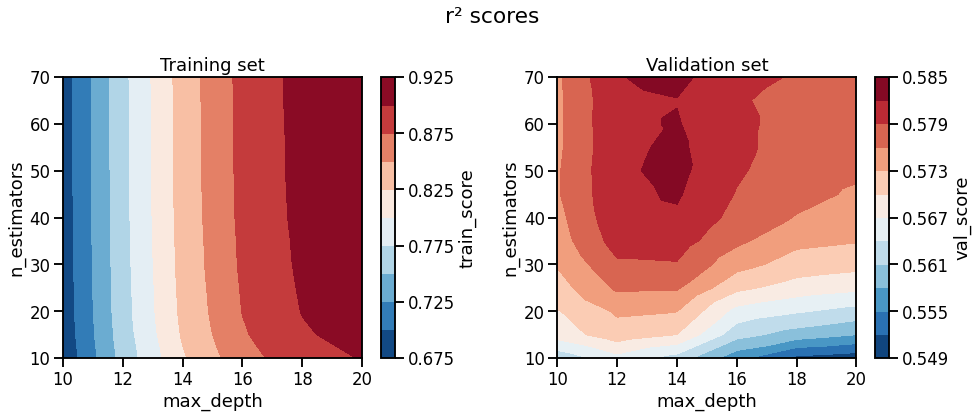

In [225]:
def compare_scores(scores, label):
    x_data = [parameters["max_depth"] for parameters in parameter_grid]
    y_data = [parameters["n_estimators"] for parameters in parameter_grid]
    plt.tricontourf(x_data, y_data, scores, levels=10, cmap="RdBu_r")
    plt.xlabel("max_depth")
    plt.ylabel("n_estimators")
    plt.colorbar().set_label(label)

plt.figure(figsize=(14, 6))
plt.suptitle("r² scores")

plt.subplot(121)
plt.title("Training set")
compare_scores(train_scores, "train_score")

plt.subplot(122)
plt.title("Validation set")
compare_scores(val_scores, "val_score")

plt.tight_layout()

Although the highest training scores are achieved by more decision trees and greater depth trees, this leads to overfitting. It looks like the best performing model (in terms of generalisation and training time) will be 50 decision trees up to a depth of 14 levels.

In [59]:
%%time

rf_model = TransformedTargetRegressor(
    RandomForestRegressor(n_estimators=50, max_depth=14, random_state=1234),
    func=transform_target,
    inverse_func=inverse_transform_target,
)

rf_model.fit(X_train, y_train)

print("RF model scores:")
print(f"Training   = {rf_model.score(X_train, y_train):0.3f}")
print(f"Validation = {rf_model.score(X_val, y_val):0.3f}")

RF model scores:
Training   = 0.835
Validation = 0.583
CPU times: user 3.21 s, sys: 0 ns, total: 3.21 s
Wall time: 3.2 s


### Neural network model

I created a simple feedforward neural network with:
* 7 neurons in the input layer
* 2 hidden layers, each with 300 nerons and using a ReLU activiation
* 2 nerons in the output layer (with no actiation) to predict both median gas and electricity consumption
* Optimisation of weights using the Adam optimization algorithm and mean squared error as the loss function

In [34]:
def create_nn_model():
    keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(7,)),
            keras.layers.Dense(300, activation="relu"),
            keras.layers.Dense(300, activation="relu"),
            keras.layers.Dense(2),
        ]
    )

    model.compile(optimizer="adam", loss="mse")
    return model

create_nn_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               2400      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 93,302
Trainable params: 93,302
Non-trainable params: 0
_________________________________________________________________


I transformed the property type statistics, the degree day heating values, and the target variables (but not the IMD deciles which were already unfirmly distributed between 0-1).

I trained the model for up to a maximum of 100 epochs, using a slightl large batch size of 64 for this simple dataset. To prevent overfitting I used early stopping, when the loss on the validation set did not improve for 10 consecutive epochs.

In [46]:
def transform_features(X):
    return pd.concat([
        transform_houses(X),
        X["IMDDecil"],
        transform_ddh(X["DDH"]),
    ], axis=1)

In [46]:
%%time

nn_model = create_nn_model()

history = nn_model.fit(
    transform_features(X_train),
    transform_target(y_train),
    epochs=100,
    validation_data=(
        transform_features(X_val),
        transform_target(y_val)
    ),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        #keras.callbacks.TensorBoard(f"./logs/{datetime.datetime.now()}"),
    ],
    batch_size=64,
    shuffle=True,
)

nn_model.save("../models/nn_model.h5")

Epoch 1/100
301/301 [==============================] - 1s 3ms/step - loss: 0.5031 - val_loss: 0.4366
Epoch 2/100
301/301 [==============================] - 1s 2ms/step - loss: 0.4322 - val_loss: 0.4128
Epoch 3/100
301/301 [==============================] - 1s 2ms/step - loss: 0.4115 - val_loss: 0.3921
Epoch 4/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3997 - val_loss: 0.4105
Epoch 5/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3893 - val_loss: 0.3831
Epoch 6/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3867 - val_loss: 0.3990
Epoch 7/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3807 - val_loss: 0.3927
Epoch 8/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3735 - val_loss: 0.3641
Epoch 9/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3700 - val_loss: 0.3610
Epoch 10/100
301/301 [==============================] - 1s 2ms/step - loss: 0.3683 - val_lo

Using this methodology, the model performed best on the validation set when trained for 33 epochs:

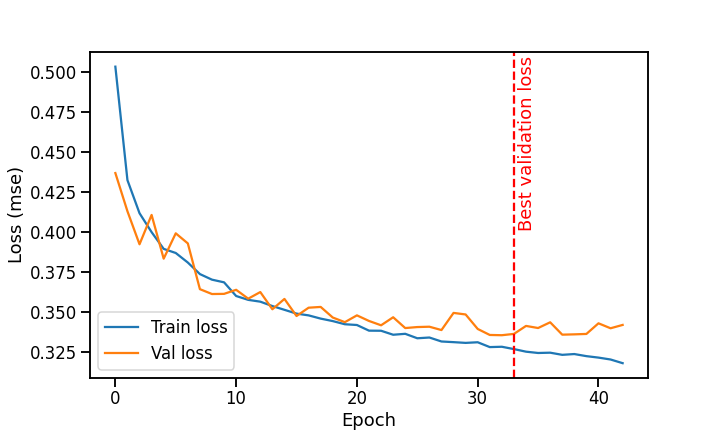

In [36]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (mse)")
plt.axvline(33, color="r", ls="--")
plt.text(33.3, 0.51, "Best validation loss", color="r", rotation=90, va="top")
plt.legend();

In [37]:
def nn_predict(X):
    return inverse_transform_target(
        nn_model.predict(
            transform_features(X)
        )
    )

print("NN model scores:")
print(f"Training   = {r2_score(y_train, nn_predict(X_train)):0.3f}")
print(f"Validation = {r2_score(y_val, nn_predict(X_val)):0.3f}")

NN model scores:
Training   = 0.615
Validation = 0.595


## Evaluation

### Evaluation on test set

The models were evaluated on the test set to estimate their generalisation error:

,Test score,Train time (approx s),Test time (approx ms)
Linear model,0.414362,0.03,2
Poly model,0.532473,0.30,12
RF model,0.572039,3.00,50
NN model,0.586080,30.00,175


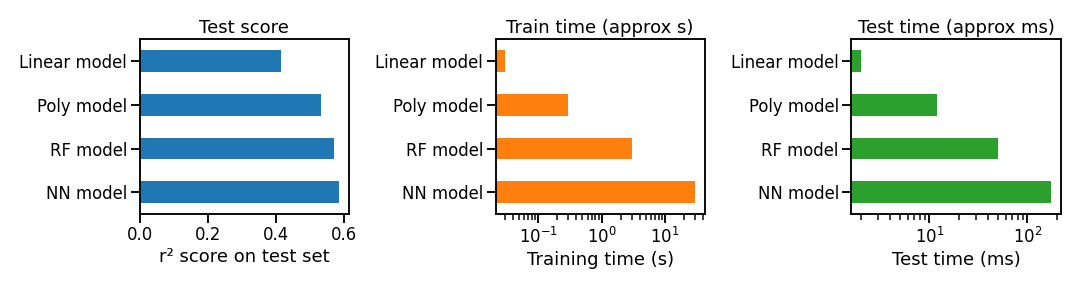

In [96]:
metrics = pd.DataFrame({
    "Test score": [
        linear_model.score(X_test, y_test),
        poly_model.score(X_test, y_test),
        rf_model.score(X_test, y_test),
        r2_score(y_test, nn_predict(X_test)),
    ],
    "Train time (approx s)": [  # For my machine, using %time (above)
        0.03,
        0.3,
        3,
        30,
    ],
    "Test time (approx ms)": [  # Calculated separately, using %%timeit
        2,
        12,
        50,
        175,
    ],
}, index=["Linear model", "Poly model", "RF model", "NN model"])

axs = metrics[::-1].plot.barh(subplots=True, layout=(1, 3), sharex=False, legend=False, figsize=(15, 4))
axs[0, 0].set_xlabel("r² score on test set")
axs[0, 1].set_xscale("log")
axs[0, 1].set_xlabel("Training time (s)")
axs[0, 2].set_xscale("log")
axs[0, 2].set_xlabel("Test time (ms)")
plt.tight_layout()

metrics

The linear model with polynomial features offers a significant improvement on the original linear model. Both the random forest and nerual network models offer further improvement over both linear models, however their performance is broadly similar (the neural network just beating the random forest).

The more complex models also take orders of magnitude longer to train and use, although all their test times are less than one second. I've only trained the neural network on my CPU, so there may be a speed-up if a GPU was used. <span style="background:yellow">(TODO)</span>

I could have continued trying to refine the models and tune hyperparameters, however improvement seems to be diminishing, implying this is probably the best I can do without gathering additional features to  describe the situation more fully.

 

### Errors analysis

#### Error distribution

Tob etter understand the performance of the models, I calculated the mean and median error that each model makes. I then calculated the standard deviation of the errors to give an idea of their spread (this also gives a sense of the ±(root mean square error) because the error distributions are roughly centred on zero).

In [125]:
linear_errors = linear_model.predict(X_test) - y_test
poly_errors = poly_model.predict(X_test) - y_test
rf_errors = rf_model.predict(X_test) - y_test
nn_errors = nn_predict(X_test) - y_test

errors = (
    pd.DataFrame({
        ("Linear", "mean"): linear_errors.mean(),
        ("Linear", "median"): linear_errors.median(),
        ("Linear", "std"): linear_errors.std(),
        ("Poly", "mean"): poly_errors.mean(),
        ("Poly", "median"): poly_errors.median(),
        ("Poly", "std"): poly_errors.std(),
        ("RF", "mean"): rf_errors.mean(),
        ("RF", "median"): rf_errors.median(),
        ("RF", "std"): rf_errors.std(),
        ("NN", "mean"): nn_errors.mean(),
        ("NN", "median"): nn_errors.median(),
        ("NN", "std"): nn_errors.std(),
    })
    .T
)

errors = errors.reindex(
    index=errors.index.rename(["Model", "Metric"]),
    columns=errors.columns.rename("Fuel"),
)

errors

Fuel                   Gas        Elec
Model  Metric                         
Linear mean     -52.232805  -11.779544
       median   197.167391   45.845407
       std     2459.139472  422.977526
Poly   mean     -35.590020   -8.865618
       median   150.458353   33.938879
       std     2138.565035  387.577310
RF     mean    -188.890061  -27.056645
       median    12.026498   15.604650
       std     2039.301193  369.656535
NN     mean    -231.345224    5.187329
       median   -51.189895   44.106421
       std     2002.967859  364.138186

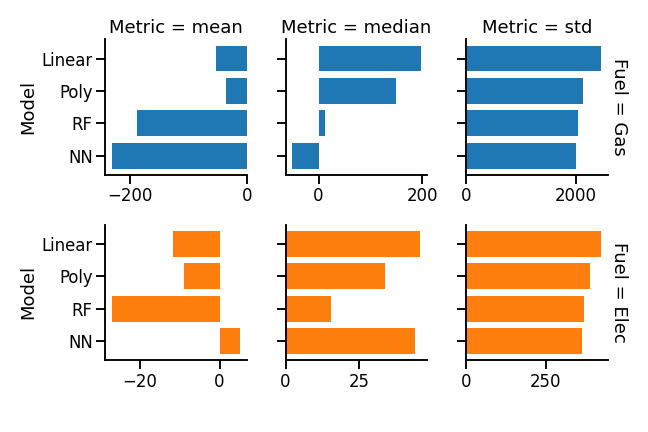

In [191]:
(
    sns.FacetGrid(
        errors[::-1].stack().reset_index(),
        row="Fuel",
        row_order=["Gas", "Elec"],
        col="Metric",
        col_order=["mean", "median", "std"],
        hue="Fuel",
        sharex=False,
        margin_titles=True,
    )
    .map(plt.barh, "Model", 0)
    .set(xlabel=None)
    .set_ylabels("Model")
);

The models with the smallest spread of errors are the random forest and neural network (as expected from their r² scores).

There also appears to be a trade-off between mean and median error. For gas consumption, the linear and polynomial have mean errors close to zero, but the median is much further from zero, indicating some kind of bias in the predictions (as expected from a high-bias, low-variance model). On the other hand, the random forest and neural network models have much smaller median errors, but much larger mean errors, indicating they are generally less biased and instead make a few very large errors (again, as expected from a higher-variance model).

Plotting the histogram of errors and a normal Q-Q plot for each of them, it is apparent the errors are approximately normally distributed, albeit with longer tails (especially the left-hand tail):

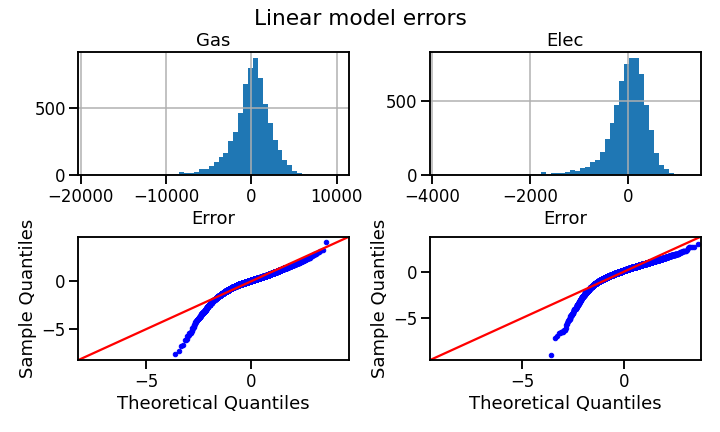

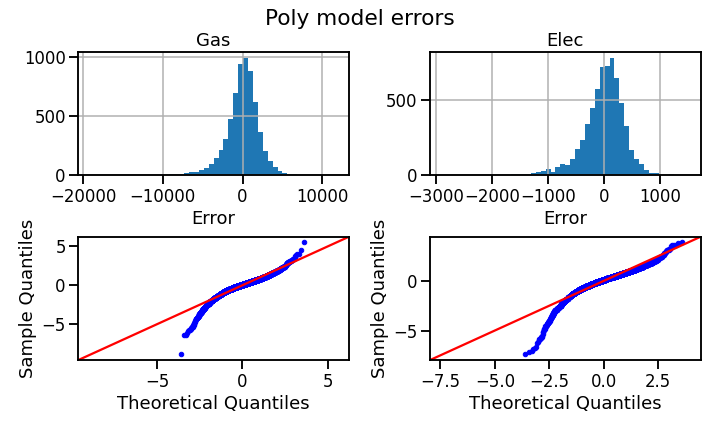

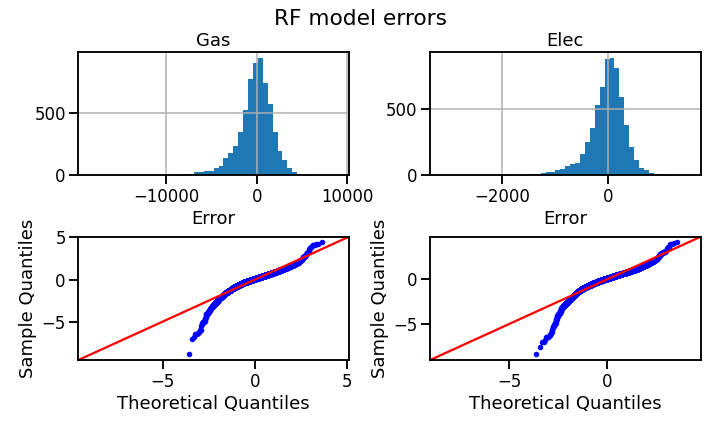

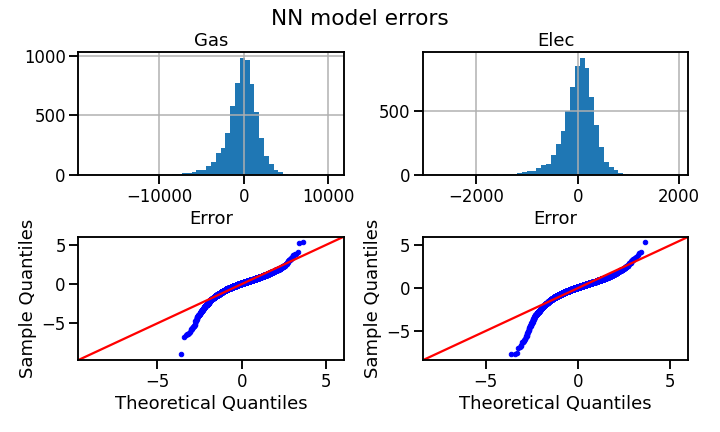

In [98]:
def error_distribution(errors, title):
    fig, axs = plt.subplots(2, 2)

    ax = errors["Gas"].hist(bins=50, label=title, ax=axs[0, 0])
    ax.set_title("Gas")
    ax.set_xlabel("Error")
    
    sm.qqplot(errors["Gas"], fit=True, line="45", marker=".", ax=axs[1, 0])
    
    ax = errors["Elec"].hist(bins=50, label=title, ax=axs[0, 1])
    ax.set_title("Elec")
    ax.set_xlabel("Error")
    
    sm.qqplot(errors["Elec"], fit=True, line="45", marker=".", ax=axs[1, 1])

    plt.suptitle(f"{title} errors")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, hspace=0.5, wspace=0.3)

error_distribution(linear_errors, "Linear model")
error_distribution(poly_errors, "Poly model")
error_distribution(rf_errors, "RF model")
error_distribution(nn_errors, "NN model")

#### Predicted vs. actual

The aforementioned biases and tails in the distrbutions of errors are more clearly visible in plot of predicted vs. actual consumption.

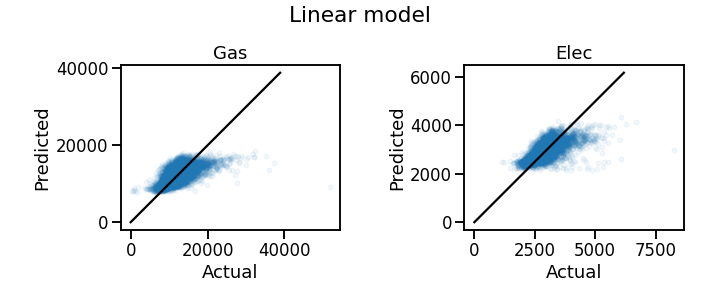

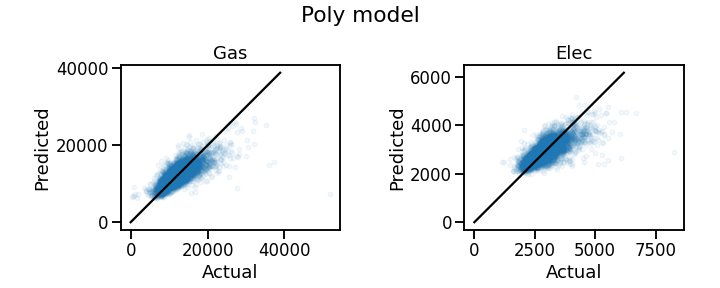

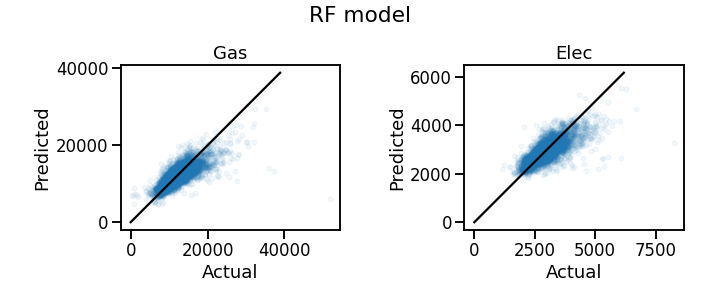

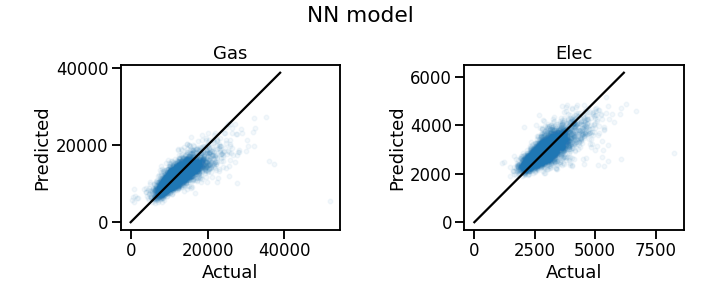

In [100]:
def error_plot(actual, predicted, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.title("Gas")
    x = actual["Gas"]
    y = predicted[:, 0]
    plt.scatter(x, y, marker=".", alpha=0.05)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    line_extent = 0.75 * max(x.max(), y.max())
    plt.plot([0, line_extent], [0, line_extent], color="k")
    plt.gca().set_aspect("equal")
    
    plt.subplot(122)
    plt.title("Elec")
    x = actual["Elec"]
    y = predicted[:, 1]
    plt.scatter(x, y, marker=".", alpha=0.05)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    line_extent = 0.75 * max(x.max(), y.max())
    plt.plot([0, line_extent], [0, line_extent], color="k")
    plt.gca().set_aspect("equal")
    
    plt.suptitle(title)
    plt.tight_layout()

error_plot(y_val, linear_model.predict(X_val), "Linear model")
error_plot(y_val, poly_model.predict(X_val), "Poly model")
error_plot(y_val, rf_model.predict(X_val), "RF model")
error_plot(y_val, nn_predict(X_val), "NN model")

The linear (and to some extent, the polynomial) models have a cluster of points less than the 45° line of unity. This suggests they are naively predicting closer to a mean value, with extreme values being incorrectly predicted. Due to the distribution of the target variables (they have long right-hand tails), this means there are more high consumptions that are under-predicted, than there are lower consumptions that are over-predicted. This explains the longer left-hand tails in the above error distributions.

This bias is still present in the even the neural network model, but it's more clearly visible by plotting the residuals directly:

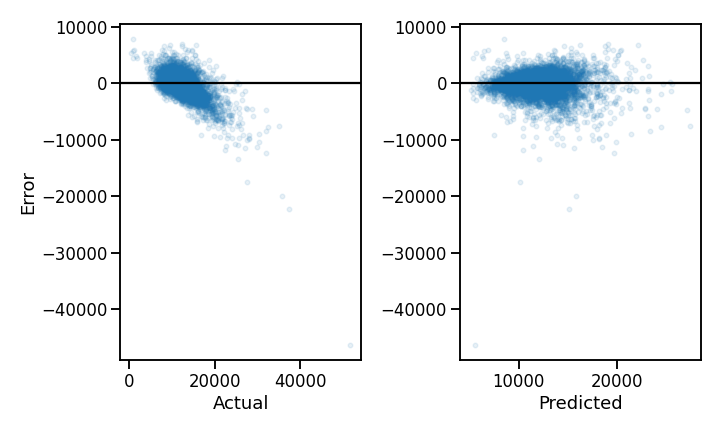

In [192]:
y_hat = nn_predict(X_val)[:, 0]

plt.subplot(121)
plt.scatter(y_val["Gas"], y_hat - y_val["Gas"], marker=".", alpha=0.1)
plt.axhline(0, color="k")
plt.xlabel("Actual")
plt.ylabel("Error")

plt.subplot(122)
plt.scatter(y_hat, y_hat - y_val["Gas"], marker=".", alpha=0.1)
plt.axhline(0, color="k")
plt.xlabel("Predicted")

plt.tight_layout()

#### 95% interval

The above error proedictions can be used to estimate a 95% coverage interval of possible errors. This could be taken as some kind of confidence interval on a preidction by the model.

In [348]:
def find_95_interval(errors):
    """Find the shortest interval giving 95% coverage."""
    errors = errors.sort_values()
    window_width = int(np.round(0.95 * len(errors)))
    smallest_window_start = (errors.shift(-window_width) - errors).dropna().argmin()
    smallest_window_end = smallest_window_start + window_width
    return f"{errors.iloc[smallest_window_start]:+0.0f}, {errors.iloc[smallest_window_end]:+0.0f}"

print("Linear model 95% interval (gas): ", find_95_interval(linear_errors["Gas"]))
print("Poly model 95% interval (gas):   ", find_95_interval(poly_errors["Gas"]))
print("RF model 95% interval (gas):     ", find_95_interval(rf_errors["Gas"]))
print("NN model 95% interval (gas):     ", find_95_interval(nn_errors["Gas"]))
print()
print("Linear model 95% interval (elec):", find_95_interval(linear_errors["Elec"]))
print("Poly model 95% interval (elec):  ", find_95_interval(poly_errors["Elec"]))
print("RF model 95% interval (elec):    ", find_95_interval(rf_errors["Elec"]))
print("NN model 95% interval (elec):    ", find_95_interval(nn_errors["Elec"]))

Linear model 95% interval (gas):  -4655, +4792
Poly model 95% interval (gas):    -4399, +3628
RF model 95% interval (gas):      -4174, +3427
NN model 95% interval (gas):      -4170, +3262

Linear model 95% interval (elec): -765, +731
Poly model 95% interval (elec):   -742, +705
RF model 95% interval (elec):     -777, +602
NN model 95% interval (elec):     -692, +672


The shortest range is given by the random forest and neural network models (as expected), and note that all the ranges are non-symmetric.

### Model stability and suitability for extrapolation

The real point of this exercise is to predict the average energy use of each property type. To achieve this, I fed in artificial data representing areas that are 100% one property type.

In [350]:
def make_sklearn_extrapolator(model):
    def extrapolate(bungalow=0, flat=0, terraced=0, semi=0, detached=0, imd=5, ddh=2000):
        X = np.vstack(np.broadcast_arrays(
            bungalow,
            flat,
            terraced,
            semi,
            detached,
            imd,
            ddh,
        )).T
        return model.predict(X)
    return extrapolate

linear_extrapolate = make_sklearn_extrapolator(linear_model)
poly_extrapolate = make_sklearn_extrapolator(poly_model)
rf_extrapolate = make_sklearn_extrapolator(rf_model)

def nn_extrapolate(bungalow=0, flat=0, terraced=0, semi=0, detached=0, imd=5, ddh=2000):
    X = np.vstack(np.broadcast_arrays(
        transform_bungalow(np.array(bungalow)),
        transform_flat(np.array(flat)),
        transform_terraced(np.array(terraced)),
        transform_semi(np.array(semi)),
        transform_detached(np.array(detached)),
        imd,
        transform_ddh(np.array(ddh)),
    )).T
    return inverse_transform_target(nn_model.predict(X))

To check the stability of this approach, I imaged a set of artifical areas that had only semi-detached and detached houses, in varying ratios. Their index of multiple deprivation and DDH were kept constant:

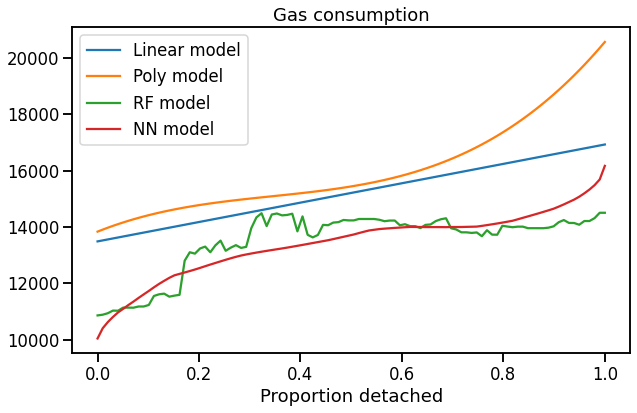

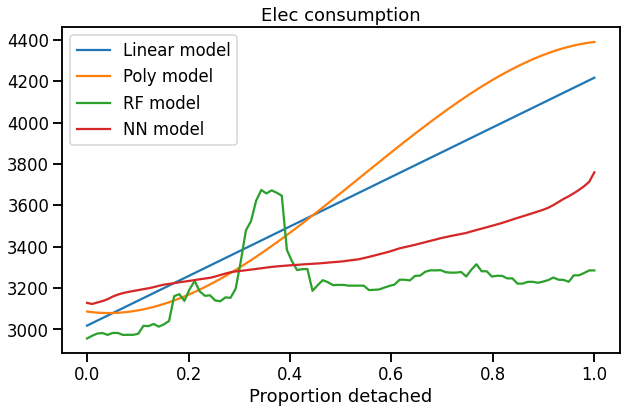

In [351]:
def property_detached_proportion_plot(gas_or_elec="gas"):
    plt.figure()
    
    x = np.linspace(0, 1, 100)
    col = 1 if gas_or_elec == "elec" else 0
    plt.plot(x, linear_extrapolate(semi=[1-i for i in x], detached=x)[:, col], label="Linear model")
    plt.plot(x, poly_extrapolate(semi=[1-i for i in x], detached=x)[:, col], label="Poly model")
    plt.plot(x, rf_extrapolate(semi=[1-i for i in x], detached=x)[:, col], label="RF model")
    plt.plot(x, nn_extrapolate(semi=[1-i for i in x], detached=x)[:, col], label="NN model")

    plt.title(f"{gas_or_elec.title()} consumption")
    plt.xlabel("Proportion detached")
    plt.legend()
    
property_detached_proportion_plot("gas")
property_detached_proportion_plot("elec")

The random forest, neural network and polynomial models can only be expected to work on input data that is within the range of values observed in training. Using polynomial model is most dangerous as it can vary wildly outside its training range.

Although the linear model is also only guaranteed to be applicable to data it has already seen, because I expect the average energy consumption in a area to _really be_ a linear combination of its constituent property types, this approach seems valid. This shows nicely that although the linear model may have less predictive power for an individual LSOA, it is likely to represent the overall pattern the best.

## Predictions

### Retrain on all data

Retrain on all available data before making predictions.

In [226]:
linear_model.fit(X, y)

poly_model.fit(X, y)

rf_model.fit(X, y)

nn_model = create_nn_model()
history = nn_model.fit(
    transform_features(X),
    transform_target(y),
    epochs=43,
)

Epoch 1/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.4691
Epoch 2/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.4092
Epoch 3/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3822
Epoch 4/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3721
Epoch 5/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3636
Epoch 6/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3606
Epoch 7/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3548
Epoch 8/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3510
Epoch 9/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3503
Epoch 10/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3461
Epoch 11/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3450
Epoch 12/43
1001/1001 [==============================] - 2s 2ms/step - loss: 0.3426
E

### Prediction of typical energy consumptions

I have plotted precited energy consumptions of each property type, and compared this with reference data (see below for details).

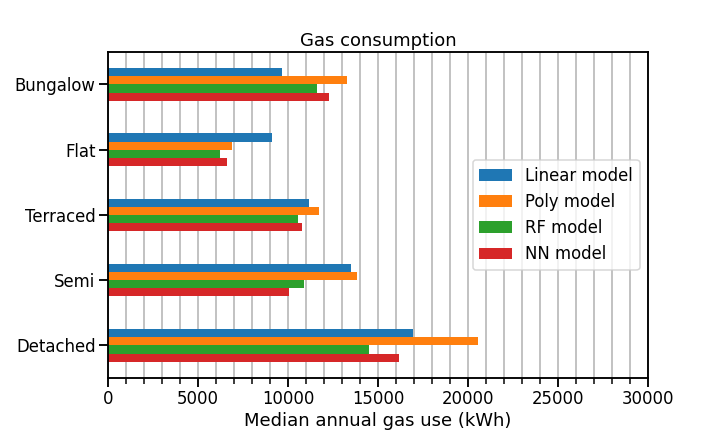

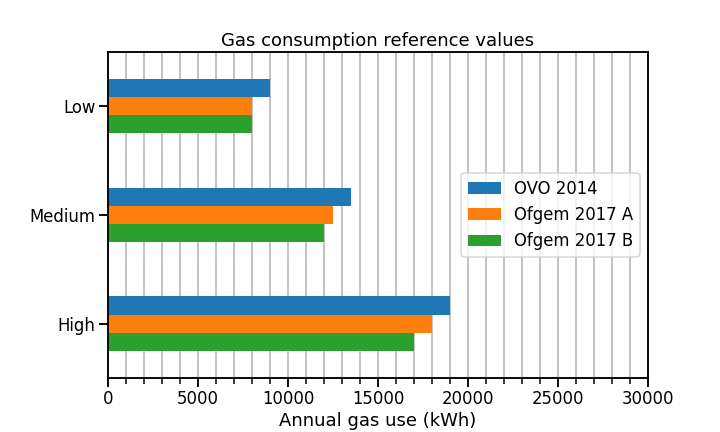

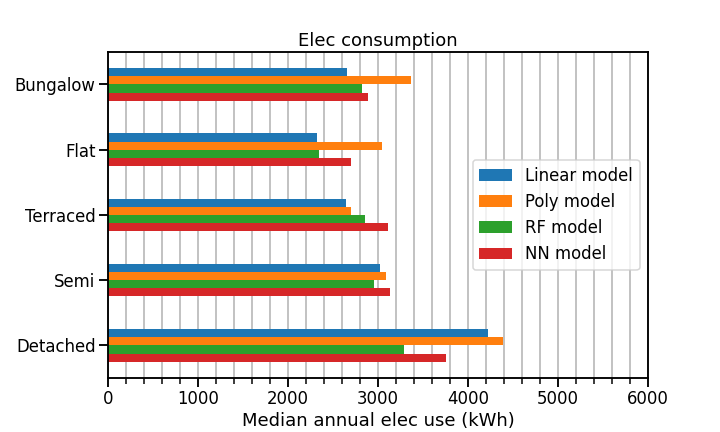

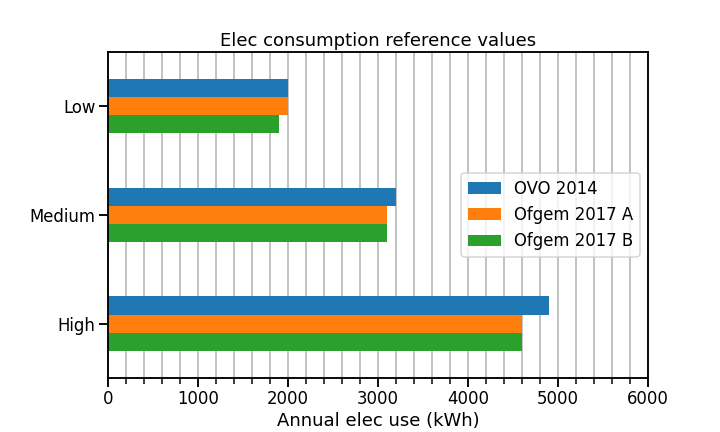

In [400]:
def property_comparison_plot(*plots, gas_or_elec="gas"):
    titles, model_extrapolators = zip(*plots)
    
    col = 1 if gas_or_elec == "elec" else 0
    data = [
        [
            model_extrapolator(bungalow=1)[0, col],
            model_extrapolator(flat=1)[0, col],
            model_extrapolator(terraced=1)[0, col],
            model_extrapolator(semi=1)[0, col],
            model_extrapolator(detached=1)[0, col],
        ]
        for model_extrapolator in model_extrapolators
    ]
    
    df = pd.DataFrame(data, columns=["Bungalow", "Flat", "Terraced", "Semi", "Detached"], index=titles)
    create_comparison_plot(df.T, title=f"{gas_or_elec.title()} consumption", xlabel=f"Median annual {gas_or_elec} use (kWh)")

def create_comparison_plot(data, title, xlabel):
    ax = data.plot.barh()
    ax.invert_yaxis()
    plt.grid(axis="x", which="both")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_axisbelow(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend(loc="center right")
    plt.subplots_adjust(left=0.15)

comparison_data = pd.DataFrame({
    "OVO 2014": [9000, 2000, 13500, 3200, 19000, 4900],
    "Ofgem 2017 A": [8000, 2000, 12500, 3100, 18000, 4600],
    "Ofgem 2017 B": [8000, 1900, 12000, 3100, 17000, 4600],
}, index=pd.MultiIndex.from_product([["Low", "Medium", "High"], ["Gas", "Elec"]]))
   
property_comparison_plot(
    ("Linear model", linear_extrapolate),
    ("Poly model", poly_extrapolate),
    ("RF model", rf_extrapolate),
    ("NN model", nn_extrapolate),
    gas_or_elec="gas",
)
plt.xlim(0, 30000)
plt.savefig("test1.png")

create_comparison_plot(
    comparison_data.xs("Gas", level=1),
    title="Gas consumption reference values",
    xlabel="Annual gas use (kWh)",
)
plt.xlim(0, 30000)
plt.savefig("test2.png")

property_comparison_plot(
    ("Linear model", linear_extrapolate),
    ("Poly model", poly_extrapolate),
    ("RF model", rf_extrapolate),
    ("NN model", nn_extrapolate),
    gas_or_elec="elec",
)
plt.xlim(0, 6000)
plt.savefig("test3.png")

create_comparison_plot(
    comparison_data.xs("Elec", level=1),
    title="Elec consumption reference values",
    xlabel="Annual elec use (kWh)",
)
plt.xlim(0, 6000);
plt.savefig("test4.png")

#### Reference data

##### OVO 2014

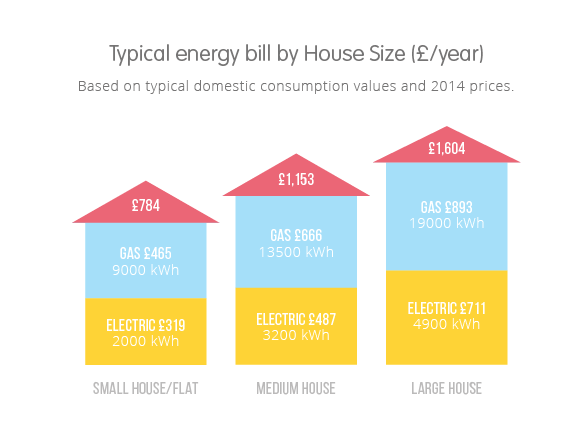

Source: OVO Energy. What is the average gas bill and average electricity bill in the UK? (2020)
https://www.ovoenergy.com/guides/energy-guides/the-average-gas-bill-average-electricity-bill-compared.html

##### Ofgem 2017 A and B

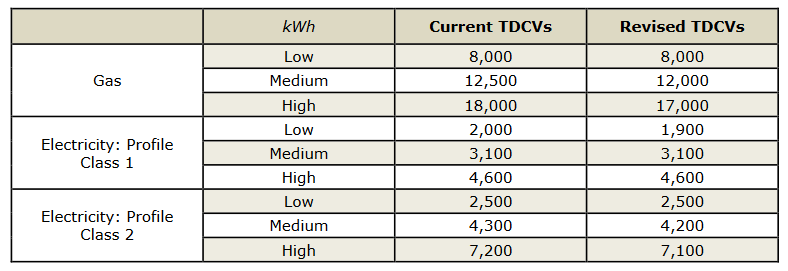

Source: Ofgem’s proposal to revise the Typical Domestic Consumption Values for gas and electricity (2017)
https://www.ofgem.gov.uk/system/files/docs/2017/08/tdcvs_2017_open_letter.pdf

#### Great Home 2020

<span style="color:red;background:yellow">(TODO)</span>

Source: Great Home. Average Energy Consumption Calculator (2020)
https://great-home.co.uk/average-energy-consumption-calculator/
(data from NEED, the National Energy Efficiency Data-Framework)

## Further work

<span style="color:red;background:yellow">Could look at bedroom number; also complete the GIS notebook</span>

## Acknowledgements

* Contains public sector information licensed under the [Open Government Licence v3](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)
* Contains National Statistics data © Crown copyright and database right 2020
* Contains OS data © Crown copyright and database right 2020

## References

1. Office for National Statistics. *[Census geography: An overview of the various geographies used in the production of statistics collected via the UK census](https://www.ons.gov.uk/methodology/geography/ukgeographies/censusgeography)*. 2016. <a id="ref-ons-stat-guide"></a>

2. OCSI. *[LSOAs, LEPs and lookups: A beginner’s guide to statistical geographies](https://ocsi.uk/2019/03/18/lsoas-leps-and-lookups-a-beginners-guide-to-statistical-geographies/)*. 2019. <a id="ref-ocsi-stat-guide"></a>

3. Department for Business, Energy & Industrial Strategy. *[Lower and Middle Super Output Areas gas consumption](https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption)* [[dataset](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/868748/LSOA_DOM_GAS_csv.zip)]. National Statistics. 2020. <a id="ref-beis-gas"></a>

4. National Grid. *[Gas Demand Forecasting Methodology](https://www.nationalgrid.com/sites/default/files/documents/8589937808-Gas%20Demand%20Forecasting%20Methodology.pdf).* 2016. <a id="ref-ng-gas-method"></a>

5. Department for Business, Energy & Industrial Strategy. *[Lower and Middle Super Output Areas electricity consumption](https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption)* [[dataset](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/868763/LSOA_DOM_ELEC_csv.zip)]. National Statistics. 2020. <a id="ref-beis-elec"></a>

6. Valuation Office Agency. *[Council tax: stock of properties, 2018](https://www.gov.uk/government/statistics/council-tax-stock-of-properties-2018)*. Table CTSOP3.1 [[dataset](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/759802/Table_CTSOP3.1_2018.csv)]. 2018. <a id="ref-ctsop"></a>

7. Ministry of Housing, Communities and Local Government. *[ English indices of deprivation 2019](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)*. Lower Super Output Area (LSOA) IMD 2019 (OSGB1936) [[dataset](https://data-communities.opendata.arcgis.com/datasets/lower-super-output-area-lsoa-imd-2019-osgb1936)]. National Statistics. 2019. <a id="ref-imd"></a>

8. Vilnis Vesma. *[UK degree-day data: Twenty-year average tables](http://www.enmanreg.org/freedd/uk-degree-day-data/)*. The Energy Management Register. 2019. <a id="ref-ddh"></a>

9. Vilnis Vesma. *[UK reporting regions 1992](http://www.enmanreg.org/wp-content/uploads/2015/04/ukddmap.gif)*. Degree Days Direct Limited. 1992. <a id="ref-ddh-map"></a>

10. Office for National Statistics. *[Lower Layer Super Output Areas (December 2011) Boundaries EW BSC](https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-ew-bsc)* [[dataset](https://opendata.arcgis.com/datasets/f213065139e3441195803b4155e71e00_0.zip)]. 2011. <a id="ref-boundaries"></a>


### Software tools

1. *[NumPy](https://numpy.org) 1.19.1*. 2020. <a id="ref-numpy"></a>

2. *[Pandas](https://pandas.pydata.org/) 1.1.0*. 2020. DOI: [10.5281/zenodo.3509134](https://doi.org/10.5281/zenodo.3509134) <a id="ref-pandas"></a>

3. *[Matplotlib]() 3.3.0*. 2020. DOI: [10.5281/zenodo.3948793](https://doi.org/10.5281/zenodo.3948793) <a id="ref-matplotlib"></a>

4. *[Seaborn](https://seaborn.pydata.org/) 0.10.1*. 2020. <a id="ref-seaborn"></a>

5. *[Scikit-learn](https://scikit-learn.org) 0.23.1*. 2020. <a id="ref-sklearn"></a>

6. *[Tensorflow](https://www.tensorflow.org/) 2.3.0*. 2020. <a id="ref-tensforflow"></a>

7. *[statsmodels](https://www.statsmodels.org/stable/index.html) 0.11.1*. 2020. <a id="ref-statsmodels"></a>

8. *[QGIS Geographic Information System](http://qgis.org) 3.14.15-Pi*. 2020. <a id="ref-qgis"></a>

9. *[GeoPandas](https://geopandas.org/) 0.8.1*. 2020. <a id="ref-geopandas"></a>